## Lesson-07 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
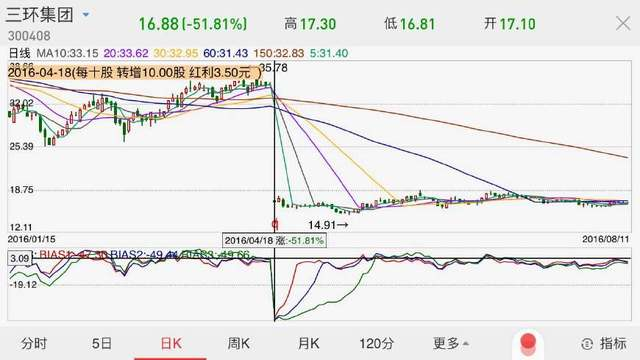

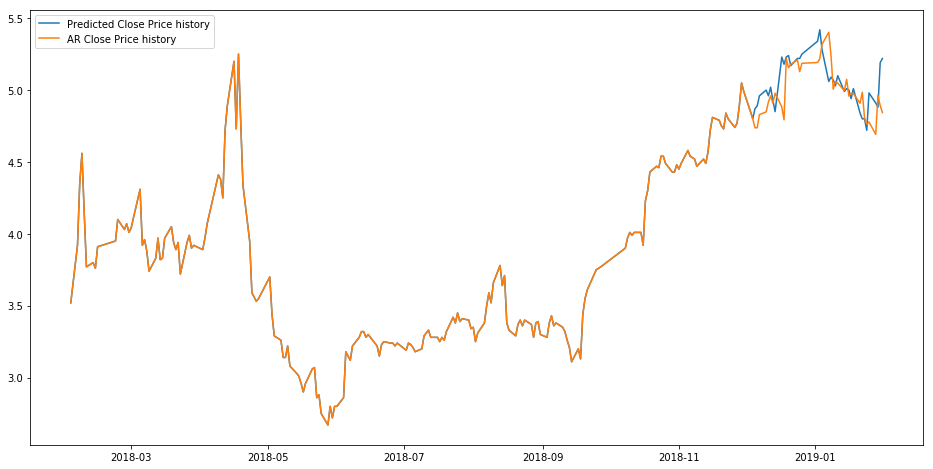

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类  这个

## 这个问题类型怎么体现出时序问题

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [1]:
from io import open
import glob  #查找符合特定规则的文件路径名
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path) #查找符合 path 规则的文件路径名

print(find_files('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [2]:
import unicodedata  #Unicode 字符数据库操作
import string  #包含关于字符串的处理函数

all_letters = string.ascii_letters + " .,;'" #生成所有字母 'a-zA-Z' + ' .,:''字符串
n_letters = len(all_letters)

print('all_letters', all_letters)
print('length', n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) #将字符串 s 格式化为 NFD 然后进行遍历
        if unicodedata.category(c) != 'Mn' #字符 c 不为 Mn (指示字符是非间距字符，这指示基字符的修改。) 
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

all_letters abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
length 57
Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [3]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n') #读入txt文件， 将文件中的人名以 '\n' 切分，删除 ' ',
    return [unicode_2_Ascii(line) for line in lines] #将文件中的名字转为 ascii 码

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0] #先分离文件名，再分离扩展名
    all_categories.append(category) #将文件对应名字加入列表中
    lines = read_lines(filename) #将文件中的名字列表赋值给 lines
    category_lines[category] = lines #对应文件中的名字列表与文件名一一对应的字典

n_categories = len(all_categories)

In [4]:
n_categories

18

In [5]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [6]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter) #查找字母对应的下标

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
# one-hot 编码
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters) #以整个字母表长度为向量维度，赋值为 0
    tensor[0][letter_to_index(letter)] = 1 #对应字母向量，以下标数值作为其权重赋值为 1，形成 one-hot
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    #在pytorch中，所有输入的数据都假设是在batch中。所以才能看到尺寸 name_length x 1 x n_letters 中的 1
    tensor = torch.zeros(len(line), 1, n_letters) #这个额外的一维是因为PyTorch假设所有的东西都是按批次的(batches)-我们只是在这里使用batch size 为 1 的batch
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1 #将各个字母对应赋值为 1，形成词向量
    return tensor

print(letter_to_tensor('J'))

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
35
torch.Size([5, 1, 57])


In [7]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

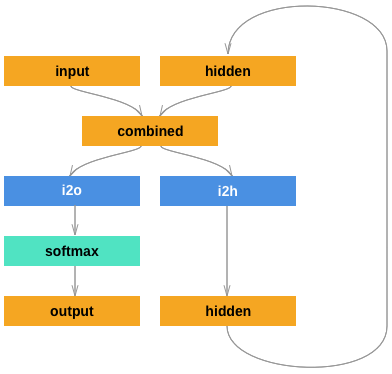

input: 输入的数据
hidden: 神经网络现有的参数矩阵
combined： input矩阵与hidden矩阵合并，两个矩阵的行数一致，input和hidden分布位于新矩阵的 左侧和右侧
i2o：对输入的数据转化为output的计算过程
12h：将输入的数据转化为hidden参数的计算过程
output：当前网络的输出
hidden：当前网络传递给下层网络的参数

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__() #使用父类进行初始化

        self.hidden_size = hidden_size #建立隐藏层

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) #隐藏层的计算
        self.i2o = nn.Linear(input_size + hidden_size, output_size) #输出层的计算
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden): #前向计算
        combined = torch.cat((input, hidden), 1) #将 input hidden 进行拼接
        hidden = self.i2h(combined) #计算隐藏层参数
        output = self.i2o(combined) #计算输出结果
        output = self.softmax(output) #输出结果加 softmax
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size) #初始化隐藏层参数

n_hidden = 128

input_size: 表征字母的向量的特征数量（向量长度）
hidden_size: 隐藏层特征数量（列数）
output_size: 语言数目，18
i2h: 隐藏网络参数的计算过程。输入的数据尺寸为input_size + hidden_size, 输出的尺寸为 hidden_size
i2o: 输出网络参数的计算过程。输入的数据尺寸为input_size + hidden_size, 输出的尺寸为 output_size

In [9]:
rnn = RNN(n_letters, n_hidden, n_categories)

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [10]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [11]:
output

tensor([[-2.8301, -2.8839, -2.9381, -2.8716, -3.0003, -2.8914, -2.8578, -2.7999,
         -2.8844, -2.8017, -2.8743, -2.9014, -2.8802, -2.8503, -2.9613, -2.9676,
         -2.8846, -2.9756]], grad_fn=<LogSoftmaxBackward>)

In [12]:
next_hidden

tensor([[ 0.0599,  0.0099, -0.0319, -0.0363, -0.0902, -0.0032, -0.0715,  0.0930,
          0.0509,  0.0718, -0.0016, -0.1110, -0.0036, -0.0051, -0.0552, -0.0120,
         -0.0084, -0.0104,  0.1083,  0.0670, -0.1070, -0.0668,  0.0545,  0.0420,
          0.0890,  0.0695,  0.0311,  0.0256, -0.0083, -0.0447,  0.0283, -0.1220,
         -0.0838,  0.0209,  0.0883, -0.0895, -0.0827, -0.0458,  0.0008, -0.0200,
         -0.0267,  0.0843,  0.0712,  0.0256, -0.0119, -0.0542, -0.0915,  0.0112,
          0.0066, -0.0063, -0.1067, -0.0471,  0.0752, -0.1309,  0.0401, -0.0311,
          0.1185, -0.1240,  0.0473,  0.0306,  0.0928,  0.0096, -0.0282, -0.0599,
         -0.0252, -0.0078,  0.0493, -0.0505, -0.0585, -0.0408,  0.0319,  0.0074,
         -0.0647, -0.1105,  0.0443, -0.0534, -0.0274,  0.0458, -0.0037, -0.0370,
         -0.1213,  0.0773, -0.0368, -0.0746,  0.0949, -0.0815, -0.1164,  0.0470,
         -0.0725, -0.1116,  0.0131, -0.0084,  0.0420, -0.0726,  0.0480, -0.0694,
         -0.0263,  0.0138, -

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [13]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8301, -2.8839, -2.9381, -2.8716, -3.0003, -2.8914, -2.8578, -2.7999,
         -2.8844, -2.8017, -2.8743, -2.9014, -2.8802, -2.8503, -2.9613, -2.9676,
         -2.8846, -2.9756]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [14]:
def category_from_output(output): 
    top_n, top_i = output.topk(1) #概率最大
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



对于刚刚产生的output，我们使用这个函数

In [15]:
print(category_from_output(output))

('Scottish', 15)


### 1.8 随机生成训练数据

In [15]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Scottish / line = Allan
category = Arabic / line = Safar
category = Greek / line = Theohari
category = Portuguese / line = Ferreiro
category = Japanese / line = Enoki
category = Russian / line = Pytalev
category = Russian / line = Dzhabrailov
category = Spanish / line = Moreno
category = English / line = Crosby
category = Vietnamese / line = an


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [16]:
criterion = nn.CrossEntropyLoss()

In [29]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [30]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 3s) 3.7004 Kassis / Greek ✗ (Arabic)
1000 10% (0m 7s) 2.2598 Roma / Japanese ✗ (Italian)
1500 15% (0m 11s) 2.9616 Herrmann / Irish ✗ (German)
2000 20% (0m 15s) 2.3282 Monette / Czech ✗ (French)
2500 25% (0m 18s) 1.0847 Rosario / Portuguese ✓
3000 30% (0m 22s) 0.9336 Gabrielli / Italian ✓
3500 35% (0m 26s) 2.2170 Hardy / Irish ✗ (French)
4000 40% (0m 30s) 2.2359 Quach / Arabic ✗ (Vietnamese)
4500 45% (0m 34s) 1.0877 Wang / Chinese ✗ (Korean)
5000 50% (0m 38s) 1.8636 Boucher / German ✗ (French)
5500 55% (0m 41s) 1.3076 Parahin / Russian ✓
6000 60% (0m 45s) 2.6355 Samson / Irish ✗ (Dutch)
6500 65% (0m 49s) 1.5637 Rodrigues / Portuguese ✓
7000 70% (0m 53s) 2.3060 Nie / Korean ✗ (Chinese)
7500 75% (0m 57s) 1.2891 Abolikhin / Russian ✓
8000 80% (1m 0s) 2.2445 Gifford / Arabic ✗ (English)
8500 85% (1m 4s) 1.2261 Hoang / Vietnamese ✓
9000 90% (1m 8s) 1.3775 Iniguez / Spanish ✓
9500 95% (1m 11s) 2.3377 Kilner / Czech ✗ (English)
10000 100% (1m 15s) 2.1776 Ramsden / Russian ✗ (English

### 1.9 观察Loss的变化

In [20]:
all_losses

[2.876305000782013,
 2.8743510150909426,
 2.8641308641433714,
 2.8586926579475405,
 2.843901028633118,
 2.853295407295227,
 2.851007466316223,
 2.8245661783218385,
 2.8319460344314575,
 2.8123922657966616,
 2.812578167915344,
 2.7885889863967894,
 2.7958075332641603,
 2.7546041345596315,
 2.6857138967514036,
 2.727653291225433,
 2.723080576658249,
 2.6934934663772583,
 2.688091025352478,
 2.624622106552124,
 2.5634815700352194,
 2.5255808409582823,
 2.5195362943410875,
 2.52427694439888,
 2.5517287719249726,
 2.5666348159313204,
 2.4911601838469504,
 2.4896636962890626,
 2.506718258857727,
 2.40761389374733,
 2.3681518745422365,
 2.4110843551158907,
 2.4420607566833494,
 2.2990614116191863,
 2.448698478937149,
 2.3391798232495784,
 2.3578742480278017,
 2.2569635927677156,
 2.3527696472406388,
 2.3158118760585786,
 2.3360660910606383,
 2.2701687359809877,
 2.2242362600564958,
 2.3510304921865464,
 2.3211589735746383,
 2.185590946674347,
 2.3607291436195372,
 2.127278689593077,
 2.238985

In [21]:
%matplotlib inline

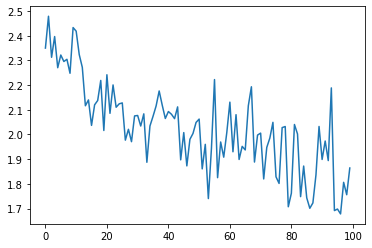

In [31]:
plt.plot(all_losses)

In [ ]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')

## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

In [24]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size[0]
        
        #添加三层layers
        self.i2h_1 = nn.Linear(input_size + hidden_size[0], hidden_size[1])
        self.i2o_1 = nn.Linear(input_size + hidden_size[0], output_size[0])
        
        self.i2h_2 = nn.Linear(hidden_size[1], hidden_size[2])
        self.i2o_2 = nn.Linear(output_size[0], output_size[1])
        
        self.i2h_3 = nn.Linear(hidden_size[2], hidden_size[0])
        self.i2o_3 = nn.Linear(output_size[1], output_size[2])
        
        #添加激活函数,对 softmax 结果取对数，dim 为待计算的对应维度
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input, hidden):
        #定义前向函数
        combined = torch.cat((input, hidden), 1) #将 input hidden 进行拼接
        #第一层计算
        hidden = self.tanh(self.i2h_1(combined)) #计算隐藏层参数
        output = self.tanh(self.i2o_1(combined)) #计算输出结果
        
        #第二层计算
        hidden = self.tanh(self.i2h_2(hidden)) #计算隐藏层参数
        output = self.tanh(self.i2o_2(output)) #计算输出结果
        
        #第三层计算
        hidden = self.tanh(self.i2h_3(hidden)) #计算隐藏层参数
        output = self.i2o_3(output) #计算输出结果
        
        output = self.softmax(output) #输出结果加 softmax 激活函数
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size) #初始化隐藏层参数

##### 网络实例化

In [25]:
# hidden output 为三层
n_hidden = [128, 256, 512]
n_output = [128, 256, n_categories]
rnn = RNN(n_letters, n_hidden, n_output)

In [26]:
print(rnn)

RNN(
  (i2h_1): Linear(in_features=185, out_features=256, bias=True)
  (i2o_1): Linear(in_features=185, out_features=128, bias=True)
  (i2h_2): Linear(in_features=256, out_features=512, bias=True)
  (i2o_2): Linear(in_features=128, out_features=256, bias=True)
  (i2h_3): Linear(in_features=512, out_features=128, bias=True)
  (i2o_3): Linear(in_features=256, out_features=18, bias=True)
  (tanh): Tanh()
  (softmax): LogSoftmax()
)


In [27]:
#定义训练参数 
n_iters = 10000
print_every = 500
plot_every = 100
learning_rate = 0.005 

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    #随机生成一次数据
    category, line, category_tensor, line_tensor = sample_trainning()
    #进行训练
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        #打印训练结果
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 3s) 2.8943 Ba / French ✗ (Arabic)
1000 10% (0m 7s) 2.9121 Rog / French ✗ (Polish)
1500 15% (0m 11s) 2.7848 Thi / Vietnamese ✓
2000 20% (0m 14s) 2.7215 Sohda / Japanese ✓
2500 25% (0m 18s) 2.8726 Rutkowski / Vietnamese ✗ (Polish)
3000 30% (0m 22s) 2.7815 Montagne / Vietnamese ✗ (French)
3500 35% (0m 25s) 2.8340 Grot / Vietnamese ✗ (Russian)
4000 40% (0m 29s) 2.9570 Pahlke / Irish ✗ (German)
4500 45% (0m 33s) 2.7627 Wei / Italian ✗ (Chinese)
5000 50% (0m 36s) 2.7630 Warner / Irish ✗ (English)
5500 55% (0m 40s) 2.6306 Shang / Vietnamese ✗ (Chinese)
6000 60% (0m 43s) 1.3770 Papadelias / Greek ✓
6500 65% (0m 48s) 2.6611 Pho / Italian ✗ (Vietnamese)
7000 70% (0m 51s) 2.8275 Yeo / Italian ✗ (Korean)
7500 75% (0m 55s) 2.8170 Chun / Irish ✗ (Korean)
8000 80% (0m 58s) 2.0927 Tikhobrazov / Russian ✓
8500 85% (1m 2s) 2.4575 Camfrlova / Japanese ✗ (Czech)
9000 90% (1m 6s) 2.9364 Rick / Czech ✗ (English)
9500 95% (1m 10s) 1.8539 Capello / Portuguese ✗ (Spanish)
10000 100% (1m 13s) 2.8359 

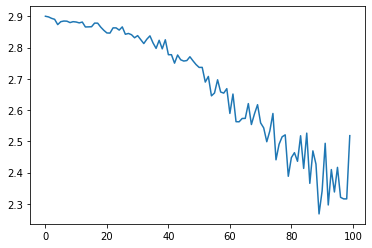

In [28]:
plt.plot(all_losses)

当设置为 3 层 layer 后，loss 比单层模型下降显著，且波动更小

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

## LSTM

In [35]:
class LSTM(nn.Module):
    #创建 lstm 模型
    def __init__(self, output_activation, criterion, input_size, hidden_size, output_size, num_layers=1):
        '''
        LSTM的用到的参数如下：
        
        input_size:输入特征维数
        bias:隐层状态是否带bias，默认为true
        batch_first:是否输入输出的第一维为batch_size，因为pytorch中batch_size维度默认是第二维度，故此选项可以将 batch_size放在第一维度。如input是(4,1,5)，中间的1是batch_size，指定batch_first=True后就是(1,4,5)
        dropout:是否在除最后一个RNN层外的RNN层后面加dropout层
        bidirectional:是否是双向RNN，默认为false，若为true，则num_directions=2，否则为1
        output_activation: 输出层激活函数
        criterion： 损失函数
        hidden_size: hidden state 和 cell state的维度
        output_size: 输出维度
        num_layers: lstm层数
        '''
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.output_activation = output_activation # o -> o
        self.criterion = criterion
        self.hidden_size = hidden_size
        
    def forward(self, input, hidden, cell):

        #定义前向传播函数
        #input: 当前时刻的输入  hidden: 前一时刻的hidden state  cell: 前一时刻的cell state
           
        # 进行前向计算，更新hidden state 和 cell state，获取output
        output, (hidden, cell) = self.lstm(input, (hidden, cell))
        # 将最后的输出尺寸转换成output_size
        output = self.i2o(output[-1])
        # 对输出施加激活函数
        output = self.output_activation(output)
        return output, hidden, cell

    def initHiddenAndCell(self):

        #初始化首次 hidden state 和 cell state
        return tuple(torch.zeros(2, 1, 1, self.hidden_size))
    
    def train_single_line(self, category_tensor, line_tensor, learning_rate=0.005):

        #单步训练
        #category_tensor: label  line_tensor: data learning_rate: 学习率
        
        hidden, cell = self.initHiddenAndCell() # 初始化hidden 和 cell

        self.zero_grad() # 将所有参数的梯度置为零

        # lin_tensor.size() = torch.Size([n, 1, 57])
        output, hidden, cell = self(line_tensor, hidden, cell) # 对输入调用 forward，计算 hidden state和cell state

        # 进行损失计算和反向传播
        loss = self.criterion(output, category_tensor) # 计算损失，传入output和label
        loss.backward() # 自动进行反向传播

        for p in self.parameters():
            # 向负梯度方向更新参数
            p.data.add_(-learning_rate, p.grad.data)

        return output, loss.item() # 返回最终输出

##### 定义训练函数

In [39]:
def fit(model, n_iters = 10000, print_every = 500, plot_every = 100, learning_rate=0.1, lr_decay=None, verbose=1):
    
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time() # 初始时间

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = sample_trainning() # 随机生成一条数据
        output, loss = model.train_single_line(category_tensor, line_tensor) # 进行训练
        current_loss += loss # 叠加损失

        if iter % print_every == 0:
            # 打印当前训练结果
            if verbose:
                guess, guess_i = category_from_output(output)
                correct = '✓' if guess == category else '✗ (%s)' % category
                print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))
            # 学习率衰减
            if lr_decay and lr_decay > 0 and lr_decay < 1:
                learning_rate *= (1 - lr_decay)

        if iter % plot_every == 0:
            # 记录损失
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    return all_losses

##### 网络实例化

In [36]:
# 选取输出的激活函数
output_activation = nn.LogSoftmax(dim=1)

# 选取损失函数
criterion = nn.CrossEntropyLoss()

# n_letters = 57
# n_categories = 18
h = 128 # hidden size

#创建实例
lstm = LSTM(output_activation, criterion, n_letters, h, n_categories)

# 模型结构
print(lstm)

LSTM(
  (lstm): LSTM(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (output_activation): LogSoftmax()
  (criterion): CrossEntropyLoss()
)


##### 1）、模型训练 n_iters=1000

500 50% (0m 1s) 2.8626 Ivor / Polish ✗ (Irish)
1000 100% (0m 3s) 2.8615 Jackson / Polish ✗ (Scottish)


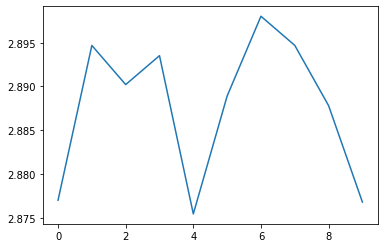

In [41]:
losses = fit(model = lstm, n_iters = 1000)
plt.plot(losses)

训练结果的曲线震荡幅度大，稳定性差

##### 2）、模型训练 n_iters=10000

500 5% (0m 1s) 2.8047 Maksimtsev / Polish ✗ (Russian)
1000 10% (0m 3s) 2.8832 Bower / Arabic ✗ (English)
1500 15% (0m 5s) 2.8427 Basurto / Vietnamese ✗ (Spanish)
2000 20% (0m 7s) 2.8930 Gerges / Spanish ✗ (Arabic)
2500 25% (0m 9s) 2.9483 Laguardia / Dutch ✗ (Italian)
3000 30% (0m 11s) 2.8936 Garner / Scottish ✗ (English)
3500 35% (0m 13s) 2.9395 Riain / Scottish ✗ (Irish)
4000 40% (0m 15s) 2.9535 Maruyama / Greek ✗ (Japanese)
4500 45% (0m 17s) 2.9252 Meadhra / Greek ✗ (Irish)
5000 50% (0m 19s) 2.9017 Santillian / Scottish ✗ (Spanish)
5500 55% (0m 20s) 2.9321 Chaput / Scottish ✗ (French)
6000 60% (0m 22s) 2.8125 Hill / English ✗ (Scottish)
6500 65% (0m 24s) 2.8768 De la fuente / Greek ✗ (Spanish)
7000 70% (0m 26s) 2.8229 Raghailligh / Irish ✓
7500 75% (0m 28s) 2.7610 Fuentes / Portuguese ✗ (Spanish)
8000 80% (0m 30s) 2.8167 Albuquerque / German ✗ (Spanish)
8500 85% (0m 32s) 2.9042 Youn / German ✗ (Korean)
9000 90% (0m 34s) 2.8742 Michel / English ✗ (Spanish)
9500 95% (0m 36s) 2.8566 Gou

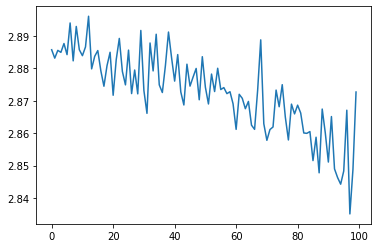

In [42]:
losses = fit(model = lstm, n_iters = 10000)
plt.plot(losses)

训练结果的曲线震荡幅度依然很大，但比之前的要好，可以明显看出下降趋势，依然有大量错误，还需要更多的训练

##### 3）、模型训练 n_iters=20000

500 2% (0m 1s) 2.8793 Tuma / Spanish ✗ (Arabic)
1000 5% (0m 3s) 2.8485 Macdonald / Spanish ✗ (Scottish)
1500 7% (0m 5s) 2.8252 Yamagata / Spanish ✗ (Japanese)
2000 10% (0m 7s) 2.8609 Rennalls / Portuguese ✗ (English)
2500 12% (0m 9s) 2.8391 Gleave / Portuguese ✗ (English)
3000 15% (0m 11s) 2.8775 Krivan / German ✗ (Czech)
3500 17% (0m 13s) 2.8654 Shalyugin / Irish ✗ (Russian)
4000 20% (0m 15s) 2.7702 Ramires / Dutch ✗ (Portuguese)
4500 22% (0m 17s) 2.8224 Farnum / Arabic ✗ (English)
5000 25% (0m 19s) 2.9314 Thai / Arabic ✗ (Vietnamese)
5500 27% (0m 21s) 2.8191 Nesselrode / Dutch ✗ (Russian)
6000 30% (0m 23s) 2.9856 Pavlik / Polish ✗ (Czech)
6500 32% (0m 25s) 2.6532 Hasenkamp / German ✓
7000 35% (0m 27s) 2.7812 Fraser / German ✗ (Scottish)
7500 37% (0m 29s) 2.8775 Mullins / Greek ✗ (French)
8000 40% (0m 31s) 2.8030 Alves / Greek ✗ (Portuguese)
8500 42% (0m 33s) 2.5588 Vourlis / Greek ✓
9000 45% (0m 35s) 2.8323 Siew / French ✗ (Chinese)
9500 47% (0m 37s) 2.7752 Urbanek / Polish ✗ (Czech)

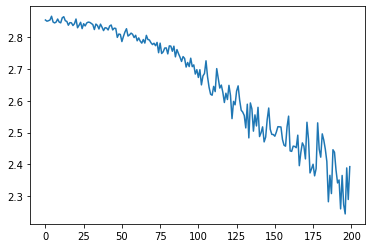

In [43]:
losses = fit(model = lstm, n_iters = 20000)
plt.plot(losses)

## GRU

In [44]:
class GRU(nn.Module):
    #创建 GRU 模型
    def __init__(self, output_activation, criterion, input_size, hidden_size, output_size, num_layers=1):
        '''
        与 LSTM 模型类似，需要用到的参数如下：
        output_activation: 输出层激活函数
        criterion： 损失函数
        input_size: 输入维度
        hidden_size: hidden state 和 cell state的维度
        output_size: 输出维度
        num_layers: gru层数
        '''
        super(GRU, self).__init__()
        self.lstm = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.output_activation = output_activation # o -> o
        self.criterion = criterion
        self.hidden_size = hidden_size
        
    def forward(self, input, hidden):
        
        #定义前向传播函数
        #input: 当前时刻的输入  hidden: 前一时刻的hidden state 
        
        # 进行前向计算，更新hidden state，获取output
        output, hidden = self.lstm(input, hidden)
        # 将最后的输出尺寸转换成output_size
        output = self.i2o(output[-1])
        # 对输出施加激活
        output = self.output_activation(output)
        return output, hidden

    def initHiddenAndCell(self):
        
        #初始化首次的 hidden state
        
        return torch.zeros(1, 1, self.hidden_size)
    
    def train_single_line(self, category_tensor, line_tensor, learning_rate=0.01):
        
        #单步训练
        #category_tensor: label  line_tensor: data learning_rate: 学习率'''

        hidden = self.initHiddenAndCell() # 初始化hidden

        self.zero_grad() # 将所有参数的梯度置为零

        # lin_tensor.size() = torch.Size([n, 1, 57])
        output, hidden = self(line_tensor, hidden) # 对输入调用forward，获取输出，hidden state

        # 进行损失计算和反向传播
        loss = self.criterion(output, category_tensor) # 计算损失，传入output和label
        loss.backward() # 自动进行反向传播

        for p in self.parameters():
            # 向负梯度方向更新参数
            p.data.add_(-learning_rate, p.grad.data)

        return output, loss.item() # 返回最终输出

##### 网络实例化

In [45]:
# 选取输出的激活函数
output_activation = nn.LogSoftmax(dim=1)

# 选取损失函数
criterion = nn.CrossEntropyLoss()

# n_letters = 57
# n_categories = 18
h = 128 # hidden size

#创建实例
gru = GRU(output_activation, criterion, n_letters, h, n_categories)

# 模型结构
print(gru)

GRU(
  (lstm): GRU(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (output_activation): LogSoftmax()
  (criterion): CrossEntropyLoss()
)


##### 1）、模型训练 n_iters=1000

500 50% (0m 1s) 2.9811 Kava / Irish ✗ (Polish)
1000 100% (0m 3s) 2.7917 O'Keefe / French ✗ (Irish)


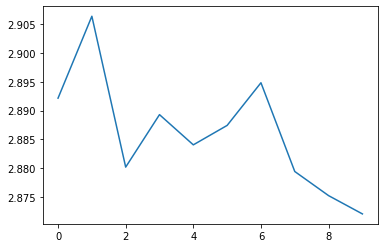

In [46]:
losses = fit(model = gru, n_iters=1000)
plt.plot(losses)

##### 2）、模型训练 n_iters=10000

500 5% (0m 2s) 2.8041 Araujo / Irish ✗ (Portuguese)
1000 10% (0m 3s) 2.6621 Chong / Korean ✓
1500 15% (0m 5s) 2.7059 Kunkel / German ✓
2000 20% (0m 7s) 3.0753 Houtum / Russian ✗ (Dutch)
2500 25% (0m 9s) 2.9245 Hor / Spanish ✗ (Chinese)
3000 30% (0m 11s) 2.9281 Wood / Spanish ✗ (Scottish)
3500 35% (0m 13s) 2.7755 Miyagi / Italian ✗ (Japanese)
4000 40% (0m 15s) 2.5817 Emmott / English ✓
4500 45% (0m 17s) 2.8891 Hardy / German ✗ (French)
5000 50% (0m 19s) 2.4575 Yoshikawa / Japanese ✓
5500 55% (0m 20s) 2.5873 Badalov / Russian ✓
6000 60% (0m 22s) 2.1847 Majewski / Polish ✓
6500 65% (0m 24s) 2.6592 Snyders / Greek ✗ (Dutch)
7000 70% (0m 26s) 2.4519 Kuipers / Greek ✗ (Dutch)
7500 75% (0m 28s) 2.1422 Paredes / Greek ✗ (Portuguese)
8000 80% (0m 30s) 2.8310 Fromm / Arabic ✗ (German)
8500 85% (0m 32s) 3.9424 Gerges / Portuguese ✗ (Arabic)
9000 90% (0m 34s) 1.4092 Wang / Korean ✓
9500 95% (0m 35s) 1.5823 Zhulebin / Russian ✓
10000 100% (0m 37s) 4.8363 Bernard / German ✗ (Polish)


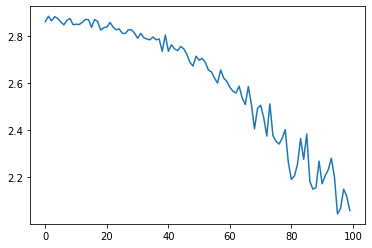

In [47]:
losses = fit(model = gru, n_iters=10000)
plt.plot(losses)

##### 3）、模型训练 n_iters=20000

500 2% (0m 1s) 3.1942 Fuchs / Portuguese ✗ (German)
1000 5% (0m 3s) 2.7919 Miller / German ✗ (Scottish)
1500 7% (0m 5s) 1.9955 Fierro / Portuguese ✗ (Italian)
2000 10% (0m 7s) 1.4758 Nao / Vietnamese ✗ (Chinese)
2500 12% (0m 9s) 4.6109 Lis / Korean ✗ (Polish)
3000 15% (0m 11s) 1.0612 Ha / Vietnamese ✓
3500 17% (0m 13s) 1.9033 Milligan / Russian ✗ (Irish)
4000 20% (0m 15s) 2.3704 Wolfe / French ✗ (English)
4500 22% (0m 17s) 2.0763 Trinh / Irish ✗ (Vietnamese)
5000 25% (0m 19s) 1.0875 Yuhanaev / Russian ✓
5500 27% (0m 21s) 1.5143 O'Brien / Irish ✓
6000 30% (0m 22s) 2.2763 Issa / Portuguese ✗ (Arabic)
6500 32% (0m 24s) 1.1643 Grzeskiewicz / Polish ✓
7000 35% (0m 26s) 0.1756 Glynatsis / Greek ✓
7500 37% (0m 28s) 5.9179 Velts / Portuguese ✗ (Russian)
8000 40% (0m 30s) 1.6756 Hiranuma / Spanish ✗ (Japanese)
8500 42% (0m 32s) 2.6417 Koeman / Irish ✗ (Dutch)
9000 45% (0m 34s) 1.5080 Venne / German ✗ (Dutch)
9500 47% (0m 36s) 1.3019 Sartre / French ✓
10000 50% (0m 38s) 0.7097 Vuu / Vietnamese ✓

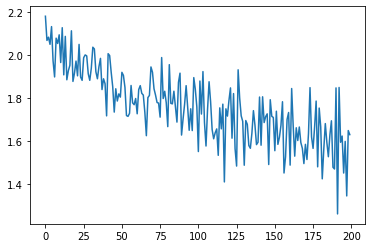

In [48]:
losses = fit(model = gru, n_iters=20000)
plt.plot(losses)

GRU 模型的效果与 LSTM 模型对比要更好，而且因为计算参数少的原因，消耗时间要少一些

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

In [79]:
class Multi_RNN(nn.Module):
    #创建多层 rnn 模型
    def __init__(self, output_activation, criterion, input_size, hidden_size, output_size, n_layers):
        super(Multi_RNN,self).__init__() ##调用父类init方法
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_szie = output_size
        
        self.hidden_activation = nn.Tanh() # 对隐层使用tanh作为激活函数
        self.output_activation = output_activation # o -> o
        self.criterion = criterion
        self.n_layers = n_layers
        
        #nn.Linear参数(input_size, output_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # 添加 input 到 hidden state 的线性计算
        self.i2o = nn.Linear(input_size + hidden_size, input_size) # 添加 input 到中间 output 的线性计算
        
        #最终输出层
        self.o2o = nn.Linear(input_size, output_size) # 添加最终 output 的线性计算
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, input, hiddens):
        # 定义前向传播函数
        
        hidden_new = torch.zeros(self.n_layers, 1, self.hidden_size) #初始化
        
        #对中间层进行迭代
        for i in range(self.n_layers):
            hidden = hiddens[i]
            combined = torch.cat((input,hidden), 1)
            hidden = self.i2h(combined)
            input = self.i2o(combined)
            hidden_new[i] = hidden
            
        #将迭代后的最终值计算输出
        output = self.o2o(input)
        output = self.softmax(output)
        return output, hidden_new
    
    def initHidden(self):
        #初始化参数
        return torch.zeros(self.n_layers, 1, self.hidden_size)
    
    def train_single_line(self, category_tensor, line_tensor, learning_rate = 0.005):
        
        hiddens = self.initHidden() # 初始化hidden state
        self.zero_grad() # 将所有参数的梯度置为零
        
        for i in range(line_tensor.size()[0]): # torch.Size([n, 1, 57]), range(n)，遍历句子中每个字
            output, hiddens = self(line_tensor[i], hiddens) # 对每个字调用forward，获取输出，更新hidden state

        # 在一条数据完整输入后，进行损失计算和反向传播
        loss = self.criterion(output, category_tensor) # 计算损失，传入output和label
        loss.backward() # 自动进行反向传播

        # Add parameters' gradients to their values, multiplied by learning rate
        for p in self.parameters():
            # 向负梯度方向更新参数
            p.data.add_(-learning_rate, p.grad.data)

        return output, loss.item() # 返回最终输出

In [85]:
# 选取输出的激活函数
output_activation = nn.LogSoftmax(dim=1)
# 选取损失函数
criterion = nn.CrossEntropyLoss()
# 实例化模型
# n_letters = 57
# n_categories = 18
h = 128 # hidden size
multi_rnn = Multi_RNN(output_activation, criterion, n_letters, h, n_categories, 5)

In [86]:
print(multi_rnn)

Multi_RNN(
  (hidden_activation): Tanh()
  (output_activation): LogSoftmax()
  (criterion): CrossEntropyLoss()
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=57, bias=True)
  (o2o): Linear(in_features=57, out_features=18, bias=True)
  (softmax): Softmax(dim=1)
)


500 5% (0m 8s) 2.8838 Gooch / Czech ✗ (English)
1000 10% (0m 15s) 2.8907 Mcintyre / Czech ✗ (Scottish)
1500 15% (0m 24s) 2.8837 Mackay / Czech ✗ (English)
2000 20% (0m 34s) 2.8958 Pinheiro / Czech ✗ (Portuguese)
2500 25% (0m 47s) 2.8830 Louverdis / Czech ✗ (Greek)
3000 30% (0m 56s) 2.8832 Tatnell / Czech ✗ (English)
3500 35% (1m 4s) 2.8812 Urista / Czech ✓
4000 40% (1m 12s) 2.8852 Snell / Czech ✗ (Dutch)
4500 45% (1m 20s) 2.8856 Del bosque / Czech ✗ (Spanish)
5000 50% (1m 28s) 2.8967 Ahn / Czech ✗ (Korean)
5500 55% (1m 37s) 2.8863 Yamamoto / Czech ✗ (Japanese)
6000 60% (1m 45s) 2.8943 Nghiem / Czech ✗ (Vietnamese)
6500 65% (1m 52s) 2.8965 Beltz / Czech ✗ (German)
7000 70% (1m 59s) 2.8923 Abel / Czech ✗ (French)
7500 75% (2m 7s) 2.8814 Macha / Czech ✓
8000 80% (2m 14s) 2.8863 Ijiri / Czech ✗ (Japanese)
8500 85% (2m 22s) 2.8954 Basurto / Czech ✗ (Portuguese)
9000 90% (2m 30s) 2.8821 Slater / Czech ✗ (English)
9500 95% (2m 38s) 2.8964 Nasato / Czech ✗ (Italian)
10000 100% (2m 46s) 2.8844 

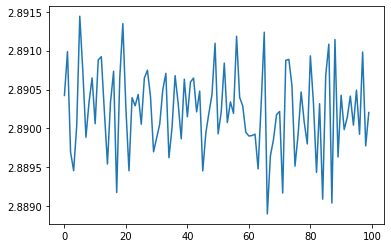

In [87]:
losses = fit(model = multi_rnn, n_iters = 10000)
plt.plot(losses)

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

In [89]:
# 选取输出的激活函数
output_activation = nn.LogSoftmax(dim=1)
# 选取损失函数
criterion = nn.NLLLoss()
# 实例化模型
# n_letters = 57
# n_categories = 18
h = 128 # hidden size
multi_rnn2 = Multi_RNN(output_activation, criterion, n_letters, h, n_categories, 5)

500 5% (0m 12s) 2.8994 O'Driscoll / Czech ✗ (Irish)
1000 10% (0m 26s) 2.8817 Markytan / Greek ✗ (Czech)
1500 15% (0m 38s) 2.8897 Cui / Greek ✗ (Chinese)
2000 20% (0m 51s) 2.8935 Piontek / Greek ✗ (Polish)
2500 25% (1m 4s) 2.8965 Baumgartner / Greek ✗ (German)
3000 30% (1m 17s) 2.8920 Vincent / Greek ✗ (French)
3500 35% (1m 29s) 2.8937 Kanaan / Greek ✗ (Arabic)
4000 40% (1m 43s) 2.8943 Trinh / Greek ✗ (Vietnamese)
4500 45% (1m 55s) 2.8940 Dao / Greek ✗ (Vietnamese)
5000 50% (2m 4s) 2.8907 Wilson / Greek ✗ (Scottish)
5500 55% (2m 11s) 2.8853 Kawazu / Greek ✗ (Japanese)
6000 60% (2m 19s) 2.8961 Ricci / Greek ✗ (Italian)
6500 65% (2m 26s) 2.8850 Nishi / Greek ✗ (Japanese)
7000 70% (2m 33s) 2.8934 Morcos / Greek ✗ (Arabic)
7500 75% (2m 41s) 2.8850 Andel / Greek ✗ (Dutch)
8000 80% (2m 48s) 2.8856 Alves / Greek ✗ (Spanish)
8500 85% (2m 56s) 2.8821 Wondracek / Greek ✗ (Czech)
9000 90% (3m 4s) 2.8958 Bohmer / Greek ✗ (German)
9500 95% (3m 11s) 2.8943 Bukoski / Greek ✗ (Polish)
10000 100% (3m 19

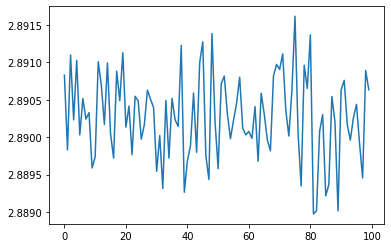

In [90]:
losses = fit(model = multi_rnn, n_iters = 10000)
plt.plot(losses)

使用 NLLLoss 与 CrossEntropyLoss 作为损失函数的训练结果基本没什么差别，这个图像显得有点别扭。